In [1]:
import cv2
import numpy
import matplotlib
import skimage
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

%matplotlib inline

In [2]:
#define a function for peak signal-to-noise ratio (PSNR)
def psnr(target,ref):#target image and refernce image
    
    #assume RGB image and convert all integer values to float
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')#need ot flatten so computations can be done
    
    rmse=math.sqrt(np.mean(diff**2.))#2. for float values
    
    return 20*math.log10(255./rmse)

#define function for mean squared error(MSE)
def mse(target,ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])#divided by total number of pixels
    
    return err

# define function that combines all three image quality metrics
def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR 
    
    return scores

In [3]:
def prepare_images(path, factor):
    for file in os.listdir(path):
        
        img = cv2.imread(path + '/' + file)
        h, w, c = img.shape
        
        # resize the image - down
        img = cv2.resize(img, (int(w / factor), int(h / factor)), interpolation = cv2.INTER_LINEAR) 
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [4]:
def modcrop(img,scale):
    tmpsz=img.shape
    sz=tmpsz[0:2]
    
    sz=sz-np.mod(sz,scale)
    
    img=img[0:sz[0],1:sz[1]]
    return img

def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [5]:
def preprocess(img):
    image_path = "images/{}".format(img)
    
    degraded = cv2.imread(image_path)
    degraded = modcrop(degraded,3)
            
    ref = cv2.imread("source/{}".format(img))
    ref=modcrop(ref,3)
            
    reconstructed = cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
    luminance = numpy.zeros((1, reconstructed.shape[0], reconstructed.shape[1], 1),dtype=float)
            
    luminance[0,:,:,0]= reconstructed[:,:,0].astype(float) / 255
    
    return degraded, ref, reconstructed, luminance


def postprocess(prediction, reconstructed):
    prediction *= 255
    prediction[prediction[:] > 255] = 255
    prediction[prediction[:] < 0] = 0
    prediction = prediction.astype(np.uint8)
    
    processed_reconstruct = shave(reconstructed, 6)
    processed_reconstruct[:,:,0] = prediction[0,:,:,0]
    
    output = cv2.cvtColor(processed_reconstruct, cv2.COLOR_YCrCb2BGR)
    
    return output


def all_scores(degraded, reference, reconstructed):
    scores = []
#     scores.append(compare_images(degraded, reference))
    scores.append(compare_images(reconstructed, reference))
                  
    return scores
                  
def predict(img, image_path, model):
    path, file = os.path.split(image_path)
            
    degraded, reference, reconstructed, luminance = preprocess(img)
            
    prediction = model.predict(luminance, batch_size = 1)
            
    bgr_output = postprocess(prediction, reconstructed)
    reference = shave(reference.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
            
    scores = all_scores(degraded, reference, bgr_output)
                  
    return (reference, degraded, bgr_output, scores, img)

In [6]:
class Super_Resolution_Model:
    def __init__(self):
        self.SRCNN = Sequential()
    
        self.SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform', activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
        self.SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True))
        self.SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='linear', padding='valid', use_bias=True))

        self.SRCNN.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error', metrics=['mean_squared_error'])
    
    def load(self):
        self.SRCNN.load_weights('3051crop_weight_200.h5')
        
    def __call__(self, images):
        ims = []
        for img in os.listdir(images):
            predictions = predict(img, images, self.SRCNN)
            ims.append(predictions)

        return np.array(ims)

In [7]:
from PIL import Image
def display_and_save(image_pairs):
    for image in image_pairs:
        # ((ref, degraded, reconst, scores, file), ( , , , , ))
        reference, degraded, reconstructed, scores, file = image
        
        print('Saving {}'.format(file))
        im = Image.fromarray(reconstructed[:,:,::-1])
        im.save("output/{}.jpg".format(file))
        # os.path.splitext(file)[0]
        
        fig, axs = plt.subplots(1, 3, figsize=(20, 8))

        axs[0].imshow(cv2.cvtColor(reference, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Original')
#         axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
#         axs[1].set_title('Degraded')
#         axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
        axs[1].imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
        axs[1].set_title('SRCNN')
        axs[1].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))

In [8]:
model = Super_Resolution_Model()

In [9]:
model.load()

images = model("images/")

1/1 [==============================] - 0s 242ms/step


C:\Users\tanay\AppData\Local\Temp\ipykernel_21032\985885467.py:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR


1/1 [==============================] - 1s 1s/step


C:\Users\tanay\AppData\Local\Temp\ipykernel_21032\3408909940.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ims)


Saving comic.bmp
Saving hubble-1.jpg
Saving jw-image-1.jpg
Saving jw-image-2.jpg
Saving jw-image-3.jpg
Saving jw-image-4.jpg
Saving jw-image-5.png


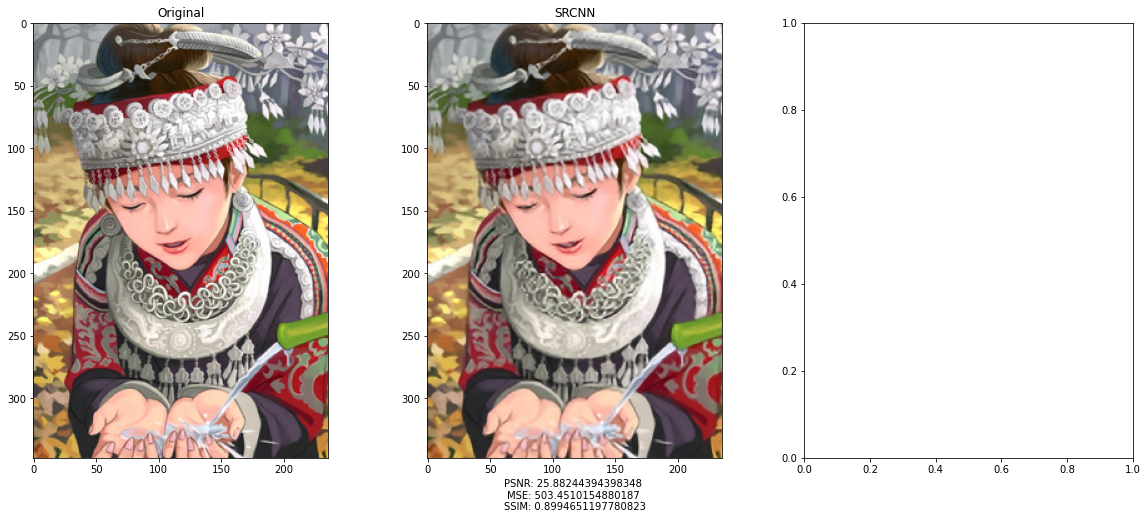

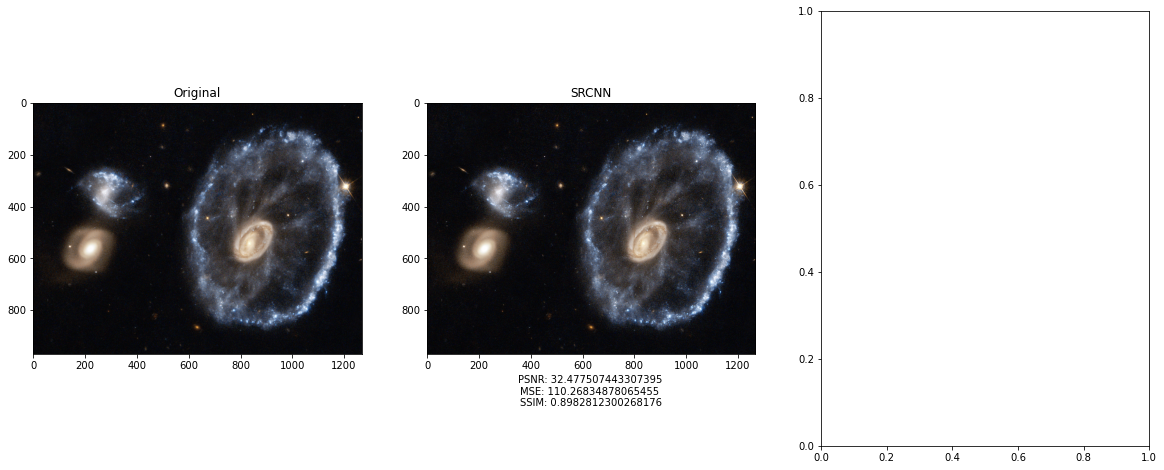

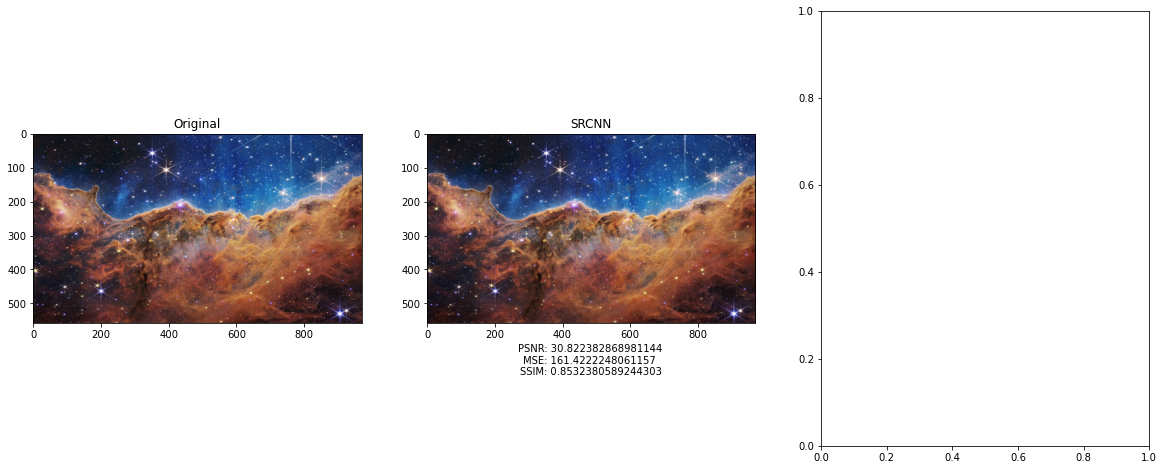

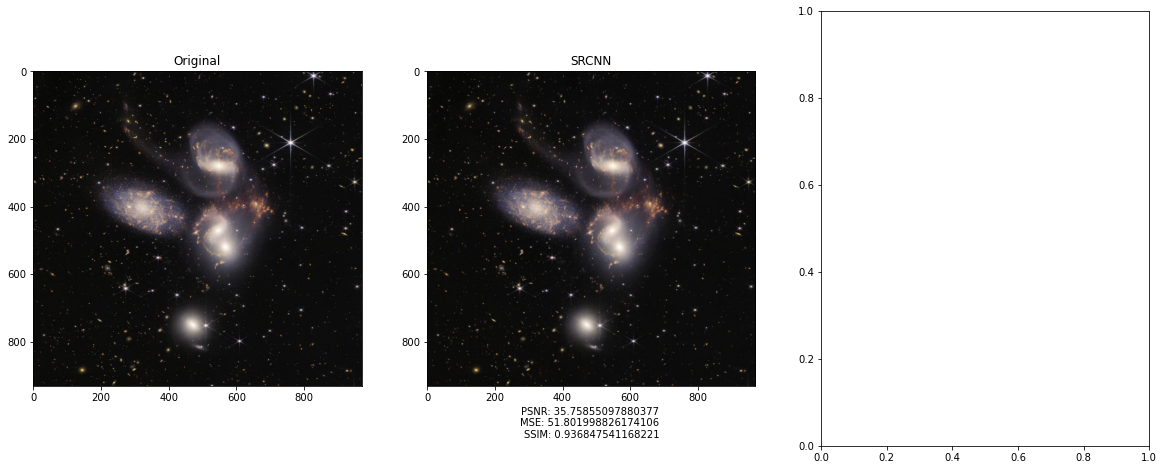

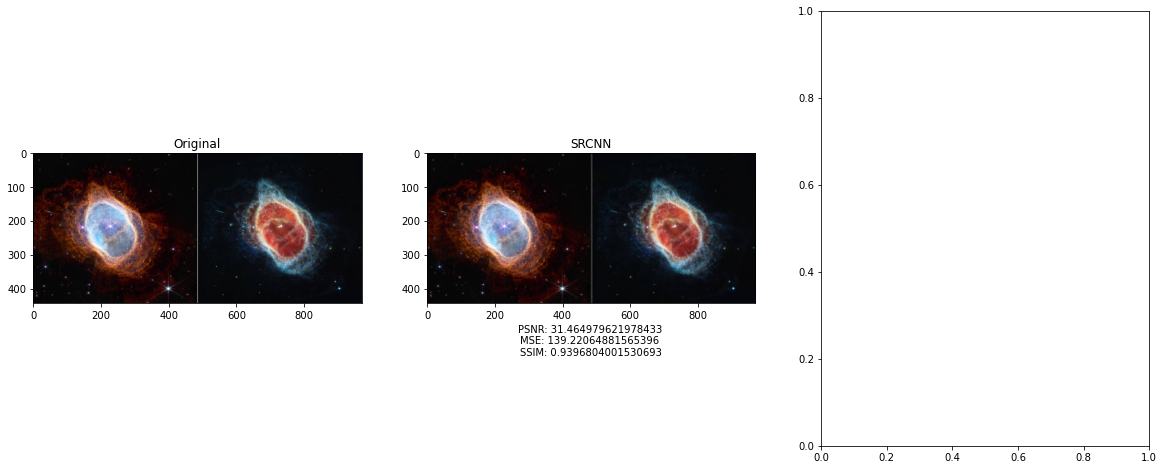

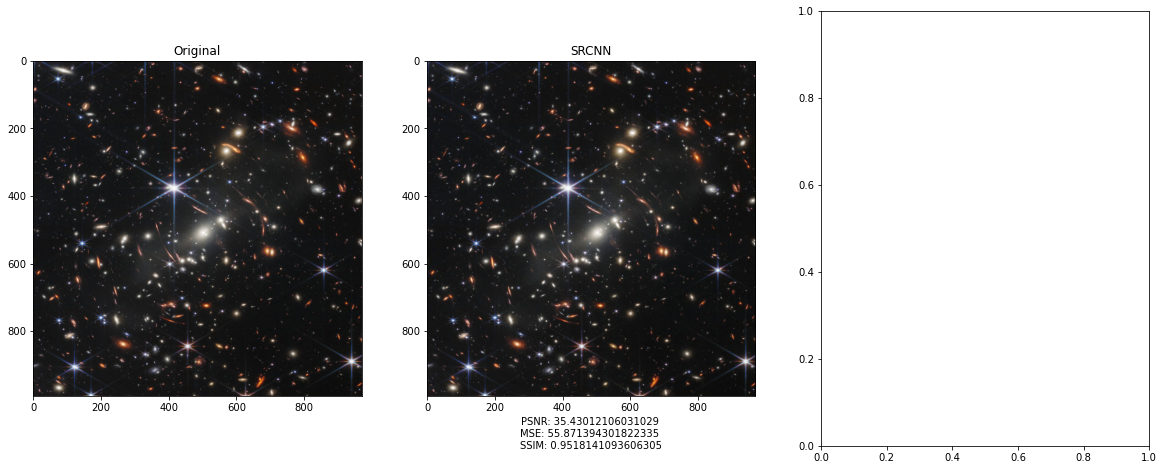

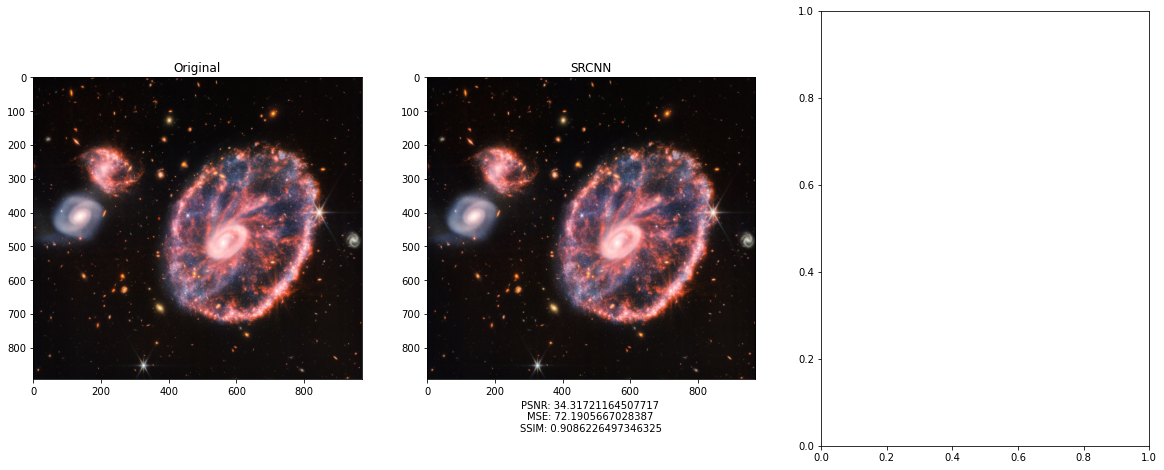

In [10]:
display_and_save(images)